In [1]:
from ROOT import TFile, gDirectory
import ROOT as r
import os

Welcome to JupyROOT 6.16/00


In [2]:
%%time
#test if kernel is running

print('running')

running
CPU times: user 114 µs, sys: 83 µs, total: 197 µs
Wall time: 157 µs


Build files into TChain

In [3]:
%%time
filename = 'ttbar_nonallhad_HF_PhPy8_AFII_mc16a.root'
treename = 'nominal_Loose'

list_of_files = os.listdir('../data_ttbar/')
data_files = [f for f in list_of_files if 'data' in f]
mc_files = [ 'ttbar_nonallhad_incl_PhPy8_AFII_mc16a.root', 'ttbar_nonallhad_incl_PhPy8_AFII_mc16d.root','ttbar_nonallhad_incl_PhPy8_AFII_mc16e.root',
            'ttX_mc16e.root','ttX_mc16d.root','ttX_mc16a.root',
            'vjets_Sherpa_mc16e.root','vjets_Sherpa_mc16d.root', 'vjets_Sherpa_mc16a.root',
            'singleTop_mc16e.root','singleTop_mc16d.root','singleTop_mc16a.root',
            'multiV_mc16a.root','multiV_mc16d.root','multiV_mc16e.root']
#data_files = ['data15_AllYear.root']
#mc_files = ['ttbar_nonallhad_HF_PhPy8_AFII_mc16d.root']

data_chain = r.TChain(treename)
mc_chain = r.TChain(treename)

for f in data_files:
    data_chain.Add('../data_ttbar/'+f)
for f in mc_files:
    mc_chain.Add('../data_ttbar/'+ f)

data_entries = data_chain.GetEntries()
mc_entries = mc_chain.GetEntries()

print(f'There are {data_entries} data events and {mc_entries} mc events')

There are 3223533 data events and 23130773 mc events
CPU times: user 202 ms, sys: 29.7 ms, total: 232 ms
Wall time: 342 ms


In [4]:
#use lum = 140
def GetWeight(lumi,tree):
    return lumi * 1000 * tree.weight_normalise *  tree.weight_mc *  tree.weight_pileup *tree.weight_leptonSF *  tree.weight_bTagSF_MV2c10_77 *  tree.weight_jvt

Initialize histograms

In [5]:
#####
#Set Up Code
#####

met_mc = r.TH1D('met_mc', 'E^{T}_{miss}', 100, 0, .8*10**6)
jet_pt_mc = r.TH1D('jet_pt_mc', 'jet_{pt}', 100, 0, 1.5*10**6)
met_data = r.TH1D('met_data', 'E^T_{miss}', 100, 0, .8*10**6)
jet_pt_data = r.TH1D('jet_pt_data', 'jet_{pt}', 100, 0, 1.5*10**6)
mu_pt_mc = r.TH1D('mu_pt_mc', '\mu_{pt}', 100, 0, 800*10**3)
mu_pt_data = r.TH1D('mu_pt_data', '\mu_{pt}', 100, 0, 800*10**3)
ht_all_mc = r.TH1D('ht_all_mc', '\mu_{pt}', 100, 0, 4000*10**3)
ht_all_data = r.TH1D('ht_all_data', '\mu_{pt}', 100, 0, 4000*10**3)


Fill histograms

In [7]:
%%time
for jentry in range(mc_entries):
    nb = mc_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    #if (): continue
    
    
 
    jet_pt = mc_chain.jet_pt[0]
    met = mc_chain.met_met
    #mu_pt = mc_chain.mu_pt
    ht_all = mc_chain.HT_all
    
    
    weight = GetWeight(104, mc_chain)

    met_mc.Fill(met,weight)
    jet_pt_mc.Fill(jet_pt, weight)
    #mu_pt_mc.Fill(mu_pt, weight)
    ht_all_mc.Fill(ht_all, weight)


CPU times: user 27min 25s, sys: 1min 8s, total: 28min 33s
Wall time: 28min 47s


In [6]:
%%time
for jentry in range(data_entries):
    nb = data_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    #if (): continue
    
    
    jet_pt = data_chain.jet_pt[0]
    met = data_chain.met_met
    
    #mu_pt = data_chain.mu_pt

    ht_all = data_chain.HT_all
    

    met_data.Fill(met)
    jet_pt_data.Fill(jet_pt)
    #mu_pt_data.Fill(mu_pt)
    ht_all_data.Fill(ht_all)


CPU times: user 2min 2s, sys: 8.85 s, total: 2min 10s
Wall time: 2min 12s


Plot and draw settings

In [23]:
###
#Wrap Up
####
c = r.TCanvas()
#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
rp_jet_pt.Draw()
c.Draw()

c2 = r.TCanvas()
met_mc.Sumw2()
met_data.Sumw2()
rp_met = r.TRatioPlot(met_mc, met_data)

rp_met.Draw()

c2.Draw()


c3 = r.TCanvas()
jet_pt_mc.Sumw2()
jet_pt_data.Sumw2()
rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
rp_jet_pt.Draw()

c3.Draw()

Error in callback <bound method CaptureDrawnPrimitives._post_execute of <JupyROOT.helpers.utils.CaptureDrawnPrimitives object at 0x104649710>> (for post_execute):


SystemError: void TPad::SaveAs(const char* filename = "", const char* option = "") =>
    problem in C++; program state has been reset

In [20]:
c5 = r.TCanvas()
#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
#rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
c5.SetLogy(0)
rp_met.Draw()
lower_y = rp_met.GetLowerRefYaxis()
lower_y.SetTitle('MC/Data')
jet_pt_mc.Draw()
lower_y.SetRangeUser(0,8)
c5.Draw()
c5.SaveAs('jet_pt.pdf')

SystemError: void TRatioPlot::Draw(const char* chopt = "") =>
    problem in C++; program state has been reset

[/usr/lib/system/libsystem_platform.dylib] _sigtramp (no debug info)
[<unknown binary>] (no debug info)
[<unknown binary>] (no debug info)
[/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/libPyROOT.so] FastCall(long, void*, void*, void*) (no debug info)
[/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/libPyROOT.so] PyROOT::TVoidExecutor::Execute(long, void*, PyROOT::TCallContext*) (no debug info)
[/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/libPyROOT.so] PyROOT::TMethodHolder::CallFast(void*, long, PyROOT::TCallContext*) (no debug info)
[/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/libPyROOT.so] PyROOT::TMethodHolder::CallSafe(void*, long, PyROOT::TCallContext*) (no debug info)
[/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/libPyROOT.so] PyROOT::TMethodHolder::Execute(void*, long, PyROOT::TCallContext*) (no debug info)
[/opt/local/Library/Frameworks


 *** Break *** segmentation violation


dont mix HF with inc

v is vector boston

ttX is maybe tt +W,Z

plot on logy scale and test that 

In [49]:
c2 = r.TCanvas()
met_mc.Sumw2()
met_data.Sumw2()
rp_met = r.TRatioPlot(met_mc, met_data)
c2.SetLogy(1)
rp_met.Draw()
lower_y = rp_met.GetLowerRefYaxis()
lower_y.SetTitle('MC/Data')
lower_y.SetRangeUser(0,8)
c2.Draw()
c2.SaveAs('met_logy.pdf')

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.Error in callback <bound method CaptureDrawnPrimitives._post_execute of <JupyROOT.helpers.utils.CaptureDrawnPrimitives object at 0x104649710>> (for post_execute):


Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/history.py", line 834, in run
  File "</opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/decorator.py:decorator-gen-23>", line 2, in writeout_cache
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/history.py", line 58, in needs_sqlite
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/history.py", line 780, in writeout_cache
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
sqlite3.OperationalError: unable to open database file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

OSError: [Errno 24] Too many open files: '/var/folders/81/py3qj0k91qngt9hv8k2zzyz80000gn/T/tmpj96u9as0.png'

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 4 points have been skipped
Info in <TCanvas::Print>: pdf file ht_all_logy.pdf has been created


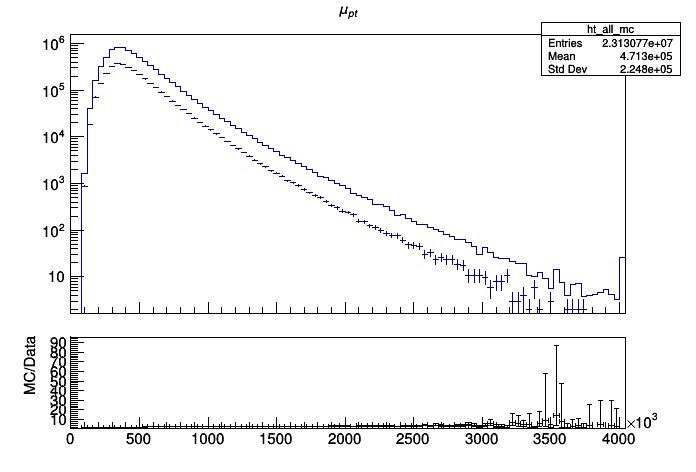

In [14]:
c3 = r.TCanvas()
met_mc.Sumw2()
met_data.Sumw2()
rp_met = r.TRatioPlot(ht_all_mc, ht_all_data)
c3.SetLogy(1)
rp_met.Draw()
lower_y = rp_met.GetLowerRefYaxis()
lower_y.SetTitle('MC/Data')
lower_y.SetRangeUser(0,1)
c3.Draw()
c3.SaveAs('ht_all_logy.pdf')